In [1]:
# different imports
import pandas as pd
import numpy as np
import os

#maybe put them with respective code
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [2]:
# Read the sample file
co_file = os.path.join("client_start_folder","Co_600K_Jul2019_6M.pkl")
ds = pd.read_pickle(co_file)

Preprocessing of data:

In [3]:
from processing.DataProcessor import DataProcessor
data_proc = DataProcessor(co_file)


zero_info_features = ["CompanyId", "CompanyNumber","CompanyName","imd"]
only_one_value_features = ["Filled", "LimitedPartnershipsNumGenPartners", "LimitedPartnershipsNumLimPartners",\
                          "Status20190701","CompanyStatus"]
complicated_features = ["RegAddressAddressLine1", "RegAddressAddressLine2", "RegAddressCareOf", "RegAddressCounty", \
                        "RegAddressPOBox", "RegAddressPostCode", "RegAddressPostTown","oa11", "PreviousName_1CompanyName"]
to_remove_cols = zero_info_features+only_one_value_features+complicated_features

data_proc.remove_columns(to_remove_cols)

In [4]:
to_num_cols = ["AccountsAccountRefDay", "AccountsAccountRefMonth", "oac1"]
to_str_cols = ["ru11ind"]

In [5]:
date_convert=[["dAccountsTimeGap","dAccountsNextDueDate","dAccountsLastMadeUpDate"],\
              ["dConfStmtTimeGap","dConfStmtNextDueDate","dConfStmtLastMadeUpDate"],\
              ["dReturnsTimeGap","dReturnsNextDueDate","dReturnsLastMadeUpDate"]]

X_train, X_test, y_train, y_test = data_proc.preprocess_data(to_num_cols, to_str_cols, date_convert)


In [6]:
#Training the Algorithm
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=7, n_estimators=20, random_state=0) # parameters to be adjusted to make most optimal 


In [7]:
#Training the Algorithm
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=7, n_estimators=20, random_state=0)
# parameters to be adjusted to make most optimal 

from ModelEvaluationTools.SKEvaluator import SKEvaluator
rf_model = SKEvaluator(classifier, "rf")


In [8]:
rf_model.fit(X_train, y_train)

In [12]:
test_auc = rf_model.evaluate(X_test, y_test)

Accuracy - Test: 0.9981833333333333
AUC - Test: 0.9300321424900496


In [13]:
rf_model.save_model()

In [15]:
# Saving X_test for use in feature importance evaluation
import pickle
filename = "X_test_data"
pickle.dump(X_test, open(filename, 'wb'))

Looking at feature importance:

C:\Users\ral20\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

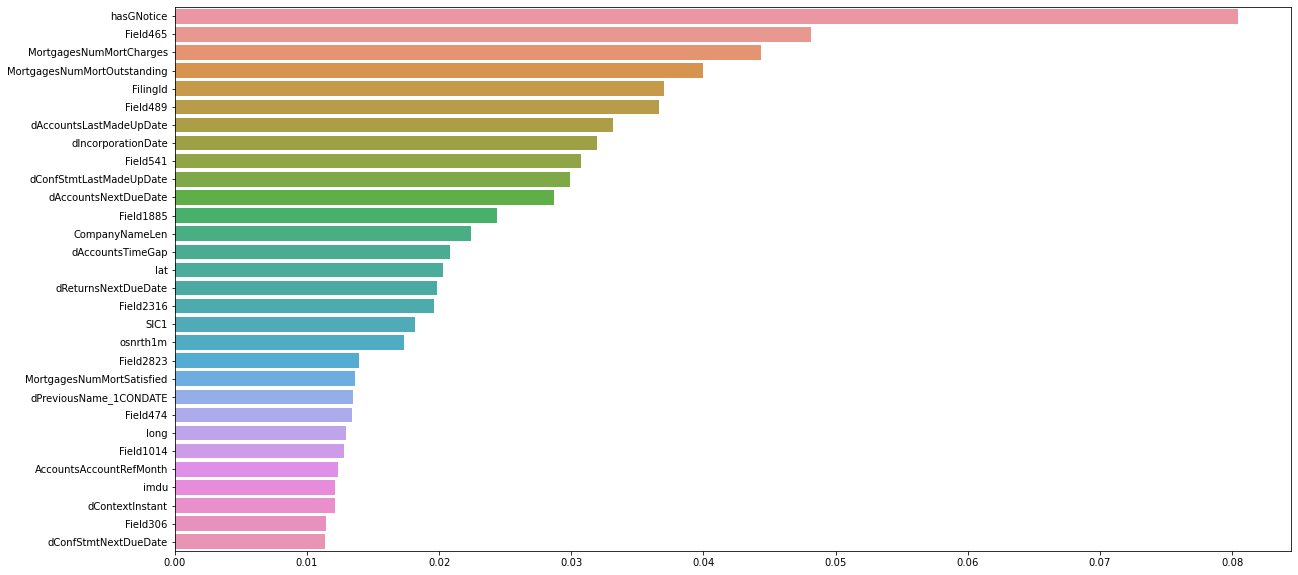

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))
sorted_feature_importance = list(sorted(zip(rf_model.model.feature_importances_, X_train.columns), key=lambda k: k[0], reverse=True))
sorted_feature_importances, sorted_features = map(list,zip(*sorted_feature_importance))
top_n = 30
sns.barplot(sorted_feature_importances[:top_n], sorted_features[:top_n])

Permutation feature importance: may cause highly correlated fields to appear less important than they actually are.

In [17]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_model.model, X_test, y_test, random_state=0)

<AxesSubplot:>

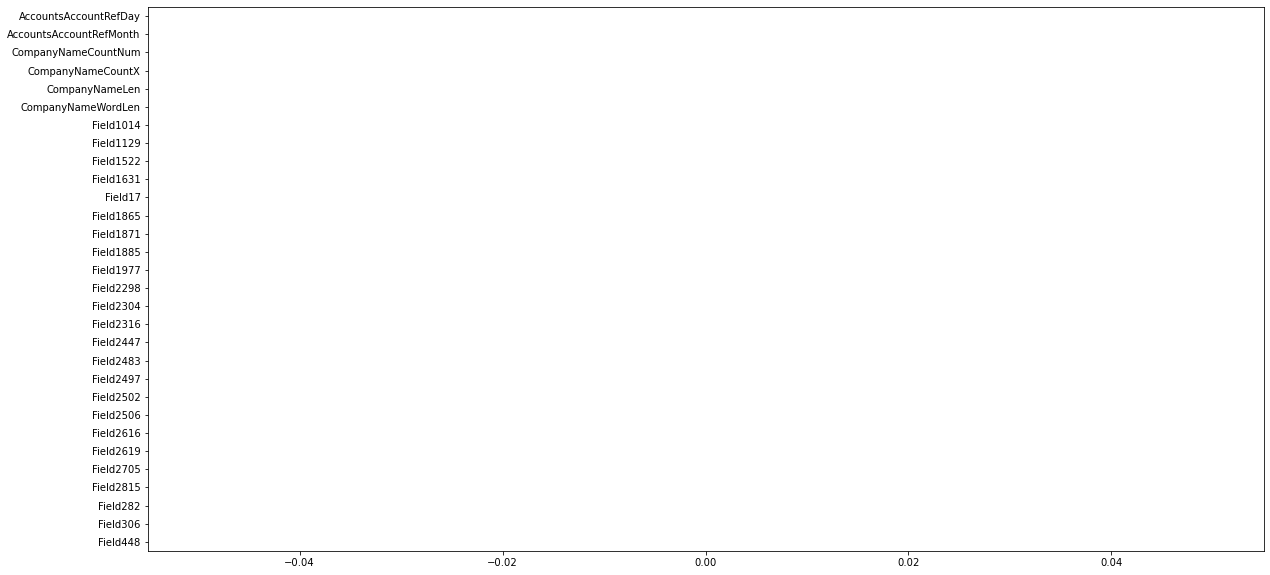

In [26]:
fig1, ax1 = plt.subplots(figsize=(20,10))
sorted_permutation_importance = list(sorted(zip(r.importances_mean, X_test.columns), key=lambda k: k[0], reverse=True))
sorted_permutation_importances, sorted_features = map(list,zip(*sorted_permutation_importance))
top_n = 30
sns.barplot(x = sorted_permutation_importances[:top_n], y = sorted_features[:top_n])

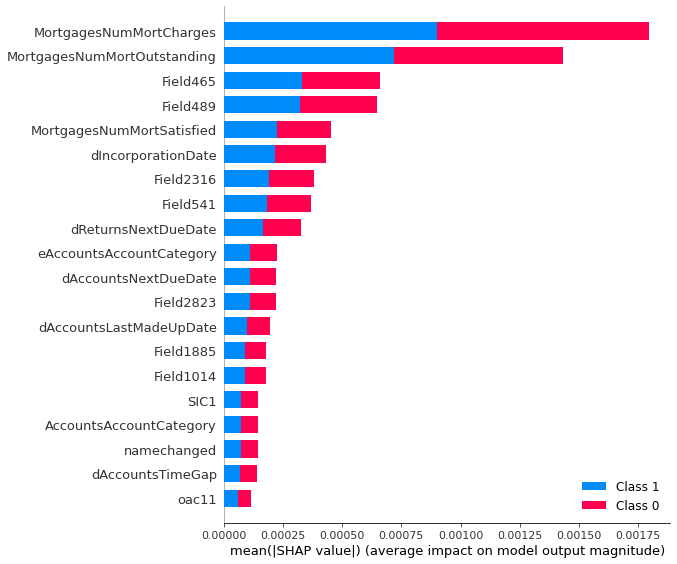

In [16]:
import shap

explainer = shap.TreeExplainer(rf_model.model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)